<a href="https://colab.research.google.com/github/snatched11/100-Days-Of-PyTorch/blob/main/Day%205%20-%20MLP_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are upgrading from:

y = Wx + b ❌ (only linear)

to:

y = W₂ · ReLU(W₁x + b₁) + b₂ ✅

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Input
x = torch.tensor([[1.0],
                  [2.0],
                  [3.0],
                  [4.0]])

# Target (quadratic)
y = torch.tensor([[1.0],
                  [4.0],
                  [9.0],
                  [16.0]])


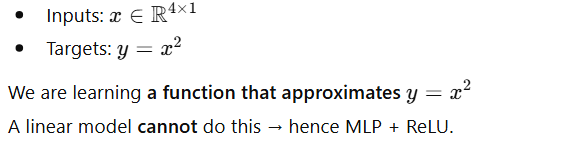

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Initializes the base nn.Module.
        # Registers parameters so PyTorch can track them for autograd + optimization.

        self.fc1 = nn.Linear(1, 4)
        # First fully-connected (dense) layer
        # Takes input of size 1 (scalar x)
        # Produces 4 outputs (4 hidden neurons)
        # Internally creates:
        #   W1: shape (4, 1)  → weights
        #   b1: shape (4,)    → bias
        # Math:
        #   z1 = W1 * x + b1
        # Each neuron learns a different linear function of x

        self.relu = nn.ReLU()
        # ReLU activation function
        # Applies element-wise:
        #   ReLU(v) = max(0, v)
        # This introduces NON-LINEARITY
        # Without this, the entire network collapses into one linear layer
        # and cannot model x² or any curved function

        self.fc2 = nn.Linear(4, 1)
        # Second fully-connected layer (output layer)
        # Takes the 4 activated values from hidden layer
        # Produces a single scalar output (ŷ)
        # Internally creates:
        #   W2: shape (1, 4)
        #   b2: shape (1,)
        # Math:
        #   y_hat = W2 * a1 + b2

    def forward(self, x):
        # Forward pass defines HOW data flows through the network
        # This is executed when you call: model(x)

        z1 = self.fc1(x)
        # Applies first linear transformation
        # If x has shape (batch_size, 1),
        # z1 has shape (batch_size, 4)
        # Math (per sample):
        #   z1 = W1 * x + b1
        # These are raw, unactivated neuron values

        a1 = self.relu(z1)
        # Applies ReLU activation element-wise
        # Any negative value in z1 becomes 0
        # Positive values remain unchanged
        # This allows neurons to "turn off"
        # and creates piecewise-linear behavior
        # Math:
        #   a1_i = max(0, z1_i)

        out = self.fc2(a1)
        # Applies second linear transformation
        # Combines the 4 activated neurons into one output
        # Math:
        #   y_hat = W2 * a1 + b2
        # This is the model's final prediction

        return out
        # Returns predicted output (ŷ)
        # Used later to compute loss against true y


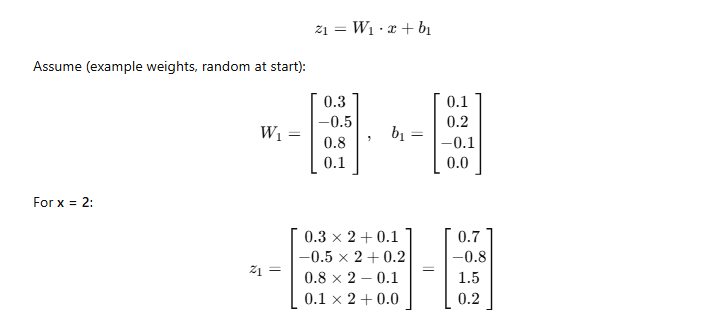

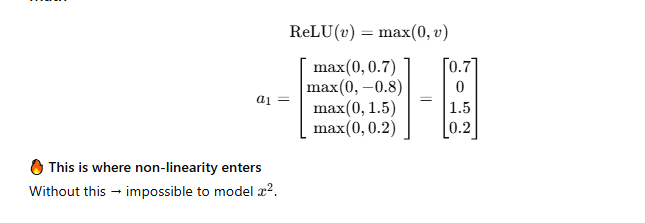

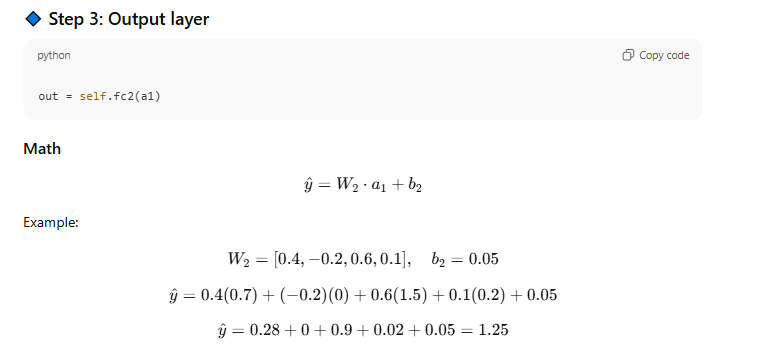

In [14]:
model = MLP()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


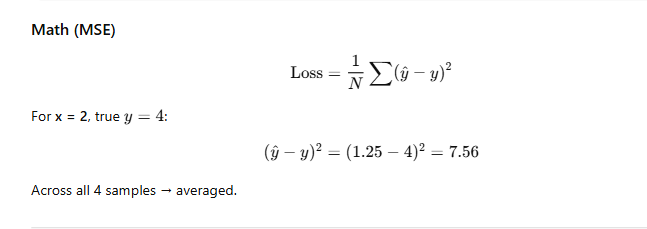

In [15]:
for epoch in range(1000):

    optimizer.zero_grad()        # 1. Clear old gradients

    y_hat = model(x)             # 2. Forward pass

    loss = loss_fn(y_hat, y)     # 3. Compute loss

    loss.backward()              # 4. Backpropagation

    optimizer.step()             # 5. Update weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 71.32939147949219
Epoch 100, Loss: 1.0621212720870972
Epoch 200, Loss: 0.47592002153396606
Epoch 300, Loss: 0.2867698073387146
Epoch 400, Loss: 0.2154693603515625
Epoch 500, Loss: 0.15504184365272522
Epoch 600, Loss: 0.10714227706193924
Epoch 700, Loss: 0.07144706696271896
Epoch 800, Loss: 0.04624015837907791
Epoch 900, Loss: 0.029215510934591293


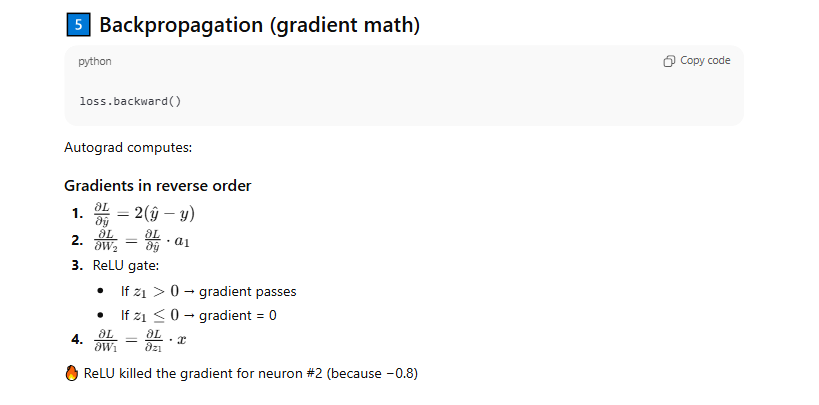

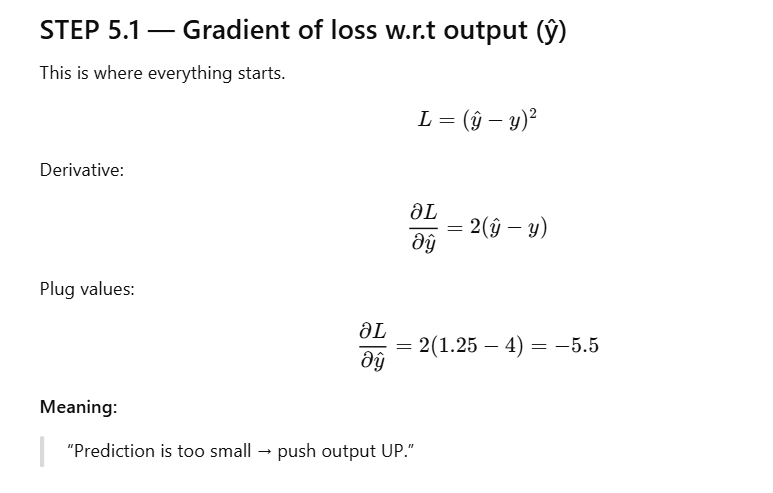

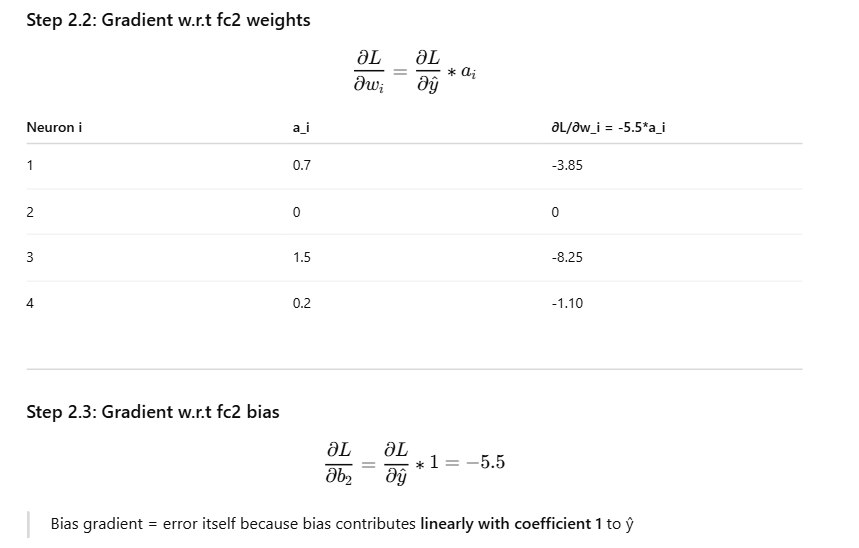

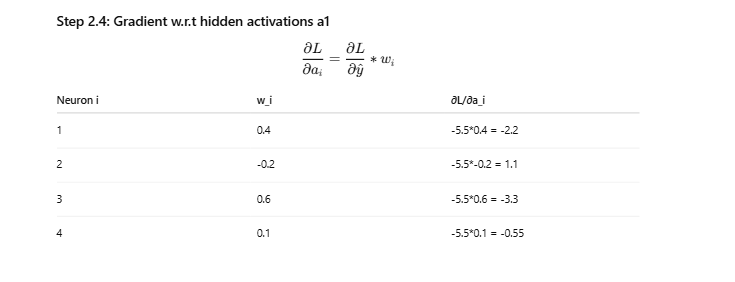

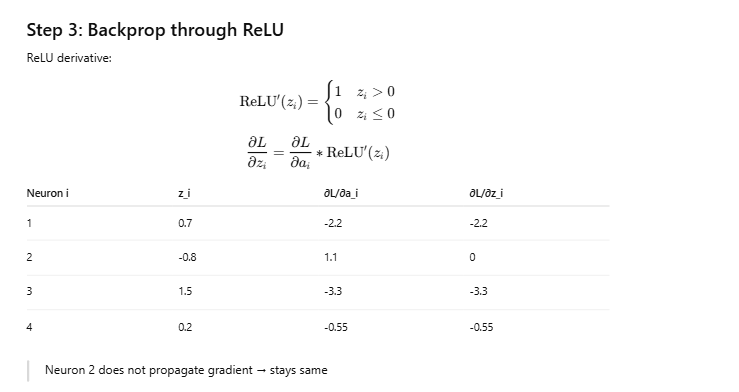

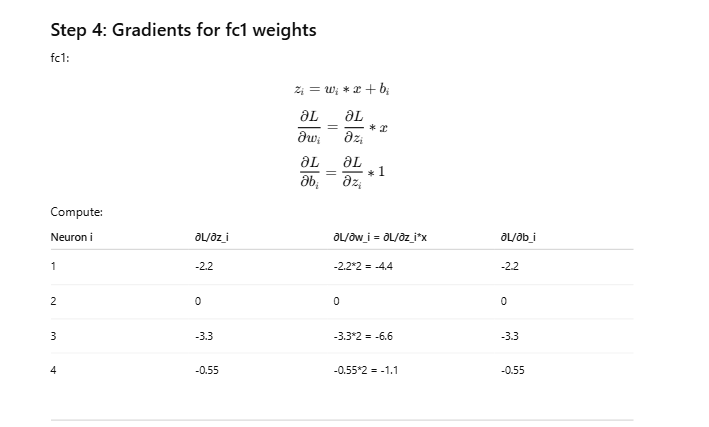

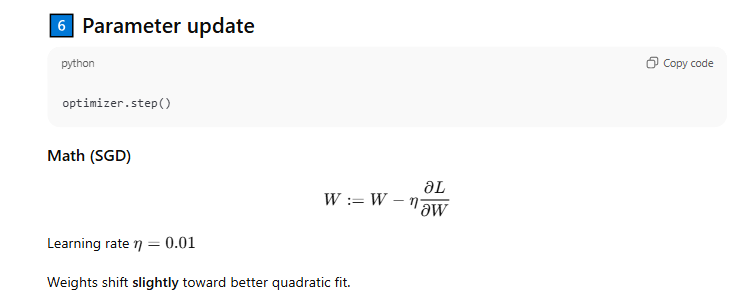

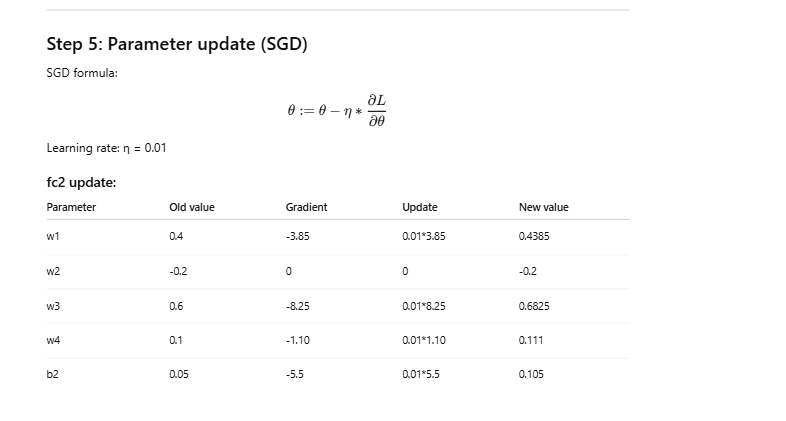

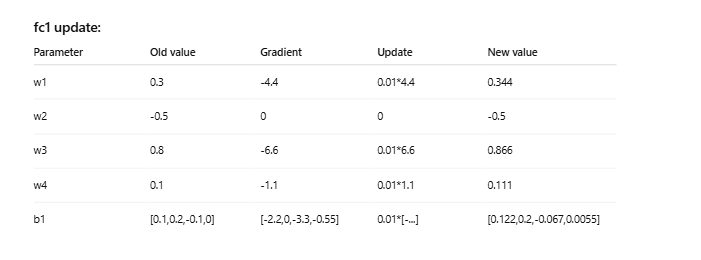

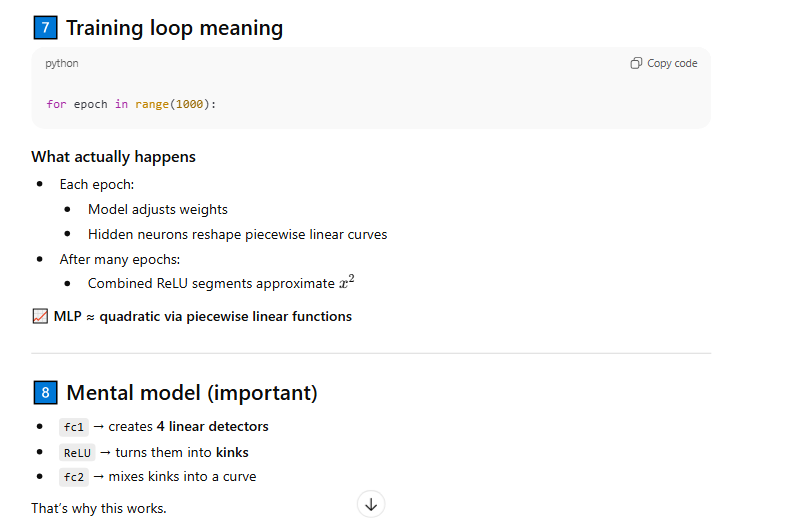

In [16]:
x = 2


**1. Why do we need activation functions?**


Without an activation function, a neural network is just a giant sequence of matrix multiplications. Since the composition of linear functions is itself a linear function, a 100-layer network without activations would be mathematically equivalent to a single-layer linear model.

Activation functions introduce non-linearity, allowing the network to learn complex patterns and "bend" the decision boundary to fit non-linear data.

**2. What happens if ReLU is removed?**

If you remove ReLU (Rectified Linear Unit), the model becomes a linear regressor. It would lose its ability to solve problems like XOR or identify complex shapes in images. Additionally, ReLU helps with sparsity; because it outputs zero for negative inputs, it "deactivates" certain neurons, making the network more computationally efficient.

**3. Why can an MLP fit quadratic data?**

According to the Universal Approximation Theorem, a Multi-Layer Perceptron (MLP) with at least one hidden layer and a non-linear activation function can approximate any continuous function (including quadratic ones) to any desired degree of accuracy. It does this by combining many small "piecewise linear" segments (from ReLUs) to mimic the curve of a parabola.

**4. What gradients pass through ReLU?**

The gradient of ReLU ($f(x) = \max(0, x)$) is binary:

If $x > 0$, the gradient is 1

If $x \leq 0$, the gradient is 0

This leads to the "Dying ReLU" problem: if a neuron's input is always negative, its gradient stays at 0, and the weights will never update again.

**5. What happens if the learning rate is too high?**

If the learning rate is too high, the optimizer takes steps that are too large. Instead of settling into a local minimum, the loss will oscillate or even diverge (explode), causing the weights to become NaN (Not a Number).

**6. Why optimizer.step() comes after backward()?**

Think of it as "Calculate then Act":

loss.backward() calculates the gradients (the direction and magnitude of change needed) using the chain rule.

optimizer.step() uses those calculated gradients to actually update the weights. If you stepped before backward, you’d be updating the weights based on the previous batch's information.

**7. Why do gradients differ every run?**

Weight initialization is random → different starting W1, W2, b1, b2.

Order of batch processing (if batch >1) may vary → gradients differ slightly.

Floating point operations introduce tiny differences.

Result: SGD trajectories are stochastic, so training is not deterministic unless seeds are fixed:

**8. How many parameters are trained?**

MLP:

fc1: Linear(1 → 4)

Weights: 1*4 = 4

Bias: 4

fc1 total = 8

fc2: Linear(4 → 1)

Weights: 4*1 = 4

Bias: 1

fc2 total = 5

Total = 8 + 5 = 13 trainable parameters

Each parameter has its own gradient.